In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as line

PATH_N = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-dash\\data\\'
PATH_C = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Veneta\\Dados Winbooks\\Despesas e Custos\\'
PATH = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Veneta\\Dados Winbooks\\Estoques\\'

# Le arquivo de Movimentos Access (Notas)
notas = pd.read_pickle(PATH_N + 'Notas.pkl')

# Separa vendas do primeiro mês
aux = notas[(notas['Produto'] > '9') & (notas['Produto'] < 'A')].groupby(['Produto', pd.Grouper(
    key='Emissao', freq='MS')]).aggregate({'Vendas': sum}).reset_index()
aux = aux[aux['Vendas'] > 0]

final = aux.loc[aux.groupby(
    'Produto')['Emissao'].idxmin()].set_index('Produto')

final.columns = ['Lancamento', 'Vendas_1M']

# Define limite dos acumulados
ultimo_mes = aux['Emissao'].max()
limite = {1: ultimo_mes + pd.offsets.MonthBegin(1),
          4: ultimo_mes + pd.offsets.MonthBegin(-3),
          6: ultimo_mes + pd.offsets.MonthBegin(-6),
          12: ultimo_mes + pd.offsets.MonthBegin(-12), }

def filtra_meses(meses, coluna):
    """Calcula soma acumulada dos meses.

    Parameters
    ----------
    notas : pandas.DataFrame
        DataFrame dos movimentos (notas)
    meses : int
        Quantidades de meses a acumular a partir do lançamento
    coluna : str
        Nome da coluna a acumular (Vendas, Estoque Terceiros, Estoque Veneta)

    Returns
    -------
    pandas.Series
        Soma acumulada a partir do lançamento, por produto
    """
    aux = notas[['Produto', coluna, 'Emissao']].copy()
    aux = aux.merge(final['Lancamento'], how='inner', on='Produto')
    aux['data_fin'] = aux['Lancamento'] + pd.offsets.MonthBegin(meses)
    aux = aux.loc[(aux['Emissao'] < aux['data_fin']) &
                  (aux['Lancamento'] < limite[meses])]
    return aux.groupby('Produto')[coluna].sum()


def estoque_medio(meses, coluna):
    """Calcula estoque médio nos primeiros meses, a partir do lançamento.

    Parameters
    ----------
    notas : pandas.DataFrame
        DataFrame dos movimentos (notas)
    meses : int
        Quantidades de meses a calcular a média a partir do lançamento
    coluna : str
        Nome da coluna a calcular a média (Estoque Terceiros, Estoque Veneta)

    Returns
    -------
    pandas.Series
        Média do estoque a partir do lançamento
    """
    aux = notas[['Produto', coluna, 'Emissao']].copy()
    aux = aux.merge(final['Lancamento'], how='inner', on='Produto')
    aux['data_fin'] = aux['Lancamento'] + pd.offsets.MonthBegin(meses)
    aux = aux.loc[(aux['Emissao'] < aux['data_fin']) &
                  (aux['Lancamento'] < limite[meses])]
    aux['CUMSUM'] = aux.groupby(
        ['Produto', pd.Grouper(key='Emissao', freq='MS')]).cumsum()
    return aux.groupby('Produto')['CUMSUM'].mean()


# Inclui vendas e consignações nos primeros meses
final['Vendas_4M'] = filtra_meses(4, 'Vendas')
final['Vendas_6M'] = filtra_meses(6, 'Vendas')
final['Vendas_12M'] = filtra_meses(12, 'Vendas')

final['Cons_4M'] = estoque_medio(4, 'Estoque Terceiros')
final['Cons_6M'] = estoque_medio(6, 'Estoque Terceiros')
final['Cons_12M'] = estoque_medio(12, 'Estoque Terceiros')

# Inclui Título da Publicação
# Lê Cadastro de Produtos
aux = pd.read_excel(PATH_C + 'Cadastro de Produtos.xlsx',
                     header=None, names=['Produto', 'Titulo'], skiprows=1, usecols='A,D', dtype=str).dropna().set_index('Produto')

final = pd.concat([final, aux], join='outer', axis=1)

# Inclui Tiragens e Custo de Produção
# Lê arquivo da Produção
pro = pd.read_excel(PATH + 'Custos de Produção - Celso.xlsx',
                    sheet_name="Tiragens", usecols="A:E",
                    header=0, parse_dates=['Data'], na_values=[None], dtype={'ISBN': str, 'Título': str, 'Custo': float, 'Tiragem': int})

# Separa Tiragem Inicial, Tiragem Total e Custo Total
aux = pro.groupby('ISBN').aggregate(
    {'Data': min, 'Tiragem': sum, 'Custo': sum})
aux['Data'] = aux['Data'] + pd.offsets.MonthBegin(2)
aux.rename({'Data': 'Data_lim', 'Tiragem': 'Tiragem Total',
            'Custo': 'Custo Total'},
           axis=1, inplace=True)

aux = pro.merge(aux, how='left', on='ISBN')

# Calcula Tiragem nos primeiros dois meses
aux = aux.loc[aux['Data'] < aux['Data_lim']].groupby(
    'ISBN').aggregate({'Tiragem': sum, 'Tiragem Total': 'first', 'Custo Total': 'first'})

final = pd.concat([final, aux], join='outer', axis=1).dropna(
    subset=['Lancamento'], axis=0)

# Calcula Venda Total
aux = notas.groupby('Produto')['Vendas'].sum()
final = pd.concat([final, aux], join='outer', axis=1).dropna(
    subset=['Lancamento'], axis=0)
final.rename({'Vendas': 'Vendas Totais'}, axis=1, inplace=True)

# Calcula Quantidade de Meses de Vendas
final['Meses'] = (ultimo_mes.year - final['Lancamento'].dt.year) * \
    12 + (ultimo_mes.month - final['Lancamento'].dt.month) + 1
final['Custo Unitário'] = final['Custo Total'] / final['Tiragem Total']

# Inclui Saldos Finais (Veneta, Terceiros, Eventos)
# Lê o arquivo do histórico dos produtos (saldo_historico_dia)
his = pd.read_csv(PATH + 'saldo_historico_dia.csv', header=0, sep=',',
                  index_col=0, dtype={'Produto': str, 'Saldo_V': int, 'Saldo_T': int, 'Saldo_E': int}, parse_dates=['Emissao'])

# Pega saldo final
aux = (ultimo_mes + pd.offsets.MonthBegin(1)).strftime('%Y-%m')
his = his.loc[his[his['Emissao'] < aux].groupby('Produto')['Emissao'].idxmax()]

# Inclui Código do Produto (ISBN)
cad = pd.read_excel(PATH_C + 'Cadastro de Produtos.xlsx', sheet_name='Cadastro',
                    usecols='A,B', header=0, dtype=str).dropna().rename({'Título WB': 'Produto'}, axis=1)

his = his.merge(cad, how='left', on='Produto')[
    ['ISBN', 'Saldo_V', 'Saldo_T', 'Saldo_E']].dropna().set_index('ISBN')

final = pd.concat([final, his], join='outer', axis=1).dropna(
    subset=['Lancamento'], axis=0)

# Inclui coluna de Perdas
final['Perda'] = final['Tiragem Total'] - final['Vendas Totais'] - \
    final['Saldo_V'] - final['Saldo_T'] - final['Saldo_E']
    
# Calcula Estoques e Vendas Consignados
CFOP_CONS = ['1918', '2918', '5918', '6917']
CFOP_VENDA = ['5114', '5119', '6114', '6119']


def estoque_cons(dados, meses):
    df = dados.reset_index(level=1)
    df = df.merge(final['Lancamento'] + pd.offsets.MonthBegin(meses),
                  how='inner', left_index=True, right_index=True, validate='many_to_one')
    df = df.loc[(df['Emissao'] < df['Lancamento']) &
                (df['Lancamento'] < limite[meses])].groupby(level=0).sum().rename(
        {'Estoque Terceiros': 'Est_Cons_{}M'.format(meses)}, axis=1)
    return df


def venda_cons(dados, meses):
    df = dados.reset_index(level=1)
    df = df.merge(final['Lancamento'] + pd.offsets.MonthBegin(meses),
                  how='inner', left_index=True, right_index=True, validate='many_to_one')
    df = df.loc[(df['Emissao'] < df['Lancamento']) &
                (df['Lancamento'] < limite[meses])].groupby(
        level=0).sum().rename({'Vendas': 'Ven_Cons_{}M'.format(meses)}, axis=1)
    return df


# Pega envios líquidos de consignação
aux = notas[(notas['Produto'] > '9') &
            (notas['Produto'] < 'A') &
            (notas['Estoque Terceiros'] == - notas['Estoque Veneta'])].groupby(
    ['Produto', pd.Grouper(key='Emissao', freq='MS')])['Estoque Terceiros'].sum()

final = pd.concat([final, estoque_cons(aux, 1)], axis=1)
final = pd.concat([final, estoque_cons(aux, 4)], axis=1)
final = pd.concat([final, estoque_cons(aux, 12)], axis=1)

# Pega Vendas de Consignação
aux = notas[(notas['Produto'] > '9') &
            (notas['Produto'] < 'A') &
            (notas['Estoque Terceiros'] == - notas['Vendas'])].groupby(
    ['Produto', pd.Grouper(key='Emissao', freq='MS')])['Vendas'].sum()

final = pd.concat([final, venda_cons(aux, 1)], axis=1)
final = pd.concat([final, venda_cons(aux, 4)], axis=1)
final = pd.concat([final, venda_cons(aux, 12)], axis=1)

# final[['Titulo', 'Lancamento', 'Tiragem', 'Vendas_1M', 'Vendas_4M',
#        'Vendas_6M', 'Vendas_12M', 'Cons_4M', 'Cons_6M', 'Cons_12M',
#        'Tiragem Total', 'Vendas Totais', 'Meses', 'Saldo_V', 'Saldo_T',
#        'Saldo_E', 'Perda', 'Custo Unitário', 'Est_Cons_1M', 'Est_Cons_4M', 'Est_Cons_12M', 'Ven_Cons_1M', 'Ven_Cons_4M', 'Ven_Cons_12M']].sort_values(by=['Lancamento', 'Vendas_1M'], ascending=[True, False]).to_excel(PATH + 'final.xlsx')


# Distribuições de Vendas

\* Excluindo-se os livros digitais e os títulos do projeto PNLD

## Distribuição das Vendas no Primeiro Mês
<br>

In [2]:
# Histograma Vendas no Primeiro Mês
PNLD = ['9788595710290', '9788595710283', '9788595710313',
        '9788595710474', '9788595710481', '9788595710498']

filtro = ~(final.index.isin(PNLD) |
           final['Titulo'].str.contains('e-?book|e-?pub', case=False))

x = final.loc[filtro, 'Vendas_1M'].astype(int)

a = x.describe()

print('Quantidade de Títulos:' + (25*' ') +
      '{:9,.0f}'.format(a[0]).replace(',', '.'))
print('Média de exemplares vendidos no primeiro mês:  ' +
      '{:9,.0f}'.format(a[1]).replace(',', '.'))
print('Menor venda no primeiro mês:' + (19*' ') +
      '{:9,.0f}'.format(a[3]).replace(',', '.'))
print('Primeiro Quartil (25%):' + (24*' ') +
      '{:9,.0f}'.format(a[4]).replace(',', '.'))
print('Segundo  Quartil (50%):' + (24*' ') +
      '{:9,.0f}'.format(a[5]).replace(',', '.'))
print('Terceiro Quartil (75%):' + (24*' ') +
      '{:9,.0f}'.format(a[6]).replace(',', '.'))
print('Maior Venda no primeiro mês:' + (19*' ') +
      '{:9,.0f}'.format(a[7]).replace(',', '.'))


Quantidade de Títulos:                               158
Média de exemplares vendidos no primeiro mês:        361
Menor venda no primeiro mês:                           1
Primeiro Quartil (25%):                               76
Segundo  Quartil (50%):                              194
Terceiro Quartil (75%):                              414
Maior Venda no primeiro mês:                       4.513


<br>

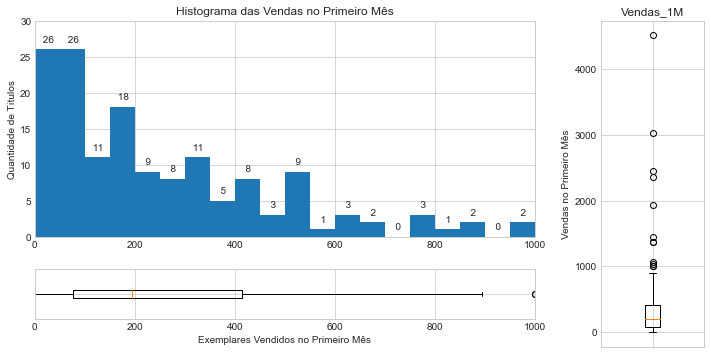

In [3]:
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(12, 12, (1, 93))

n, val, _ = ax1.hist(x, range=(0, 1000), bins=20)

# Valores de cada bin
for txt, pos in zip(n, val):
    ax1.text(pos + 11, txt+1, '{:3,.0f}'.format(txt))
ax1.set_ylim([0, 30])
ax1.set_xlim([0, 1000])
ax1.set_title('Histograma das Vendas no Primeiro Mês')
ax1.set_ylabel('Quantidade de Títulos')

ax2 = fig.add_subplot(12, 12, (109, 129))

ax2.boxplot(x, vert=False)
ax2.set_xlim([0, 1000])
ax2.set_xlabel('Exemplares Vendidos no Primeiro Mês')
ax2.tick_params(
    axis='y',           # changes apply to the y-axis
    which='both',       # both major and minor ticks are affected
    left=False,         # ticks along the left edge are off
    right=False,        # ticks along the right edge are off
    labelleft=False)  # labels along the left edge are off

ax3 = fig.add_subplot(12, 12, (11, 144))

ax3.boxplot(x)
ax3.set_ylabel('Vendas no Primeiro Mês')
ax3.set_title('Vendas_1M')
ax3.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=False,       # ticks along the bottom edge are off
    top=False,          # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off

plt.show()

<br>


#### Títulos fora da curva:

In [4]:
aux = a['50%'] + 1.5*(a['75%'] - a['25%'])

aux = final.loc[filtro & (final['Vendas_1M'] > aux),
                ['Titulo', 'Vendas_1M']
                ].sort_values('Vendas_1M', ascending=False)\
    .reset_index()
pd.set_option('display.max_colwidth', 40)
aux.columns = ['ISBN', 'Título', 'Vendas']
aux['Vendas'] = aux['Vendas'].map(
    lambda x: '{:7,.0f}'.format(x).replace(',', '.'))
aux.style.hide_index()


ISBN,Título,Vendas
9788595710702,BERLIM,4.513
9788563137685,Educacao Sob Ataque. Resistencia E Luta Dos Educadores No Parana,3.033
9788563137289,Do Inferno,2.458
9786586691405,PALESTINA,2.360
9788563137319,Caravaggio - A Morte da Virgem,1.935
9788595710740,MAU CAMINHO,1.447
9788595710368,O Perfeito Estranho,1.368
9788595710153,Ayako,1.363
9788595710146,Diastrofismo Humano,1.068
9788595710696,SABRINA,1.037


<br>

## Distribuição das Vendas nos Primeiros Quatro Meses
<br>

In [5]:
x = final.loc[filtro, 'Vendas_4M'].dropna().astype(int)

a = x.describe()

print('Quantidade de Títulos:' + (20*' ') +
      '{:9,.0f}'.format(a[0]).replace(',', '.'))
print('Média de exemplares Vendidos em 4 meses:  ' +
      '{:9,.0f}'.format(a[1]).replace(',', '.'))
print('Menor venda em 4 meses:' + (19*' ') +
      '{:9,.0f}'.format(a[3]).replace(',', '.'))
print('Primeiro Quartil (25%):' + (19*' ') +
      '{:9,.0f}'.format(a[4]).replace(',', '.'))
print('Segundo  Quartil (50%):' + (19*' ') +
      '{:9,.0f}'.format(a[5]).replace(',', '.'))
print('Terceiro Quartil (75%):' + (19*' ') +
      '{:9,.0f}'.format(a[6]).replace(',', '.'))
print('Maior Venda em 4 meses:' + (19*' ') +
      '{:9,.0f}'.format(a[7]).replace(',', '.'))


Quantidade de Títulos:                          147
Média de exemplares Vendidos em 4 meses:        851
Menor venda em 4 meses:                           2
Primeiro Quartil (25%):                         316
Segundo  Quartil (50%):                         607
Terceiro Quartil (75%):                       1.124
Maior Venda em 4 meses:                       7.508


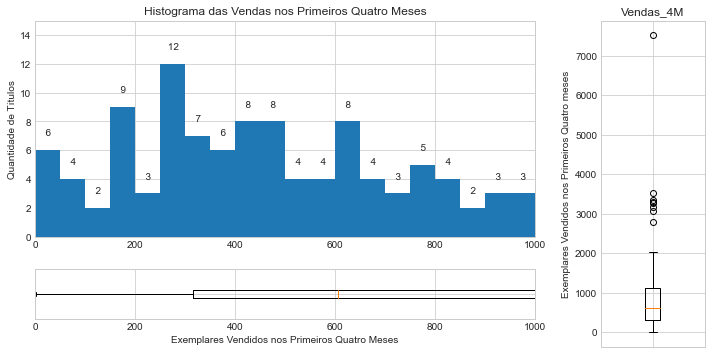

In [6]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(12, 12, (1, 93))

n, val, _ = ax1.hist(x, range=(0, 1000), bins=20)

# Valores de cada bin
for txt, pos in zip(n, val):
    ax1.text(pos + 11, txt+1, '{:3,.0f}'.format(txt))
    
ax1.set_ylim([0, 15])
ax1.set_xlim([0, 1000])
ax1.set_title('Histograma das Vendas nos Primeiros Quatro Meses')
ax1.set_ylabel('Quantidade de Títulos')

ax2 = fig.add_subplot(12, 12, (109, 129))

ax2.boxplot(x, vert=False)
ax2.set_xlim([0, 1000])
ax2.set_xlabel('Exemplares Vendidos nos Primeiros Quatro Meses')
ax2.tick_params(
    axis='y',           # changes apply to the y-axis
    which='both',       # both major and minor ticks are affected
    left=False,         # ticks along the left edge are off
    right=False,        # ticks along the right edge are off
    labelleft=False)  # labels along the left edge are off

ax3 = fig.add_subplot(12, 12, (11, 144))

ax3.boxplot(x)
ax3.set_ylabel('Exemplares Vendidos nos Primeiros Quatro meses')
ax3.set_title('Vendas_4M')
ax3.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=False,       # ticks along the bottom edge are off
    top=False,          # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off

plt.show()


<br>

#### Títulos fora da curva:

In [7]:
aux = a['50%'] + 1.5*(a['75%'] - a['25%'])

aux = final.loc[filtro & (final['Vendas_4M'] > aux),
                ['Titulo', 'Vendas_4M']
                ].sort_values('Vendas_4M', ascending=False)\
    .reset_index()
pd.set_option('display.max_colwidth', 40)
aux.columns = ['ISBN', 'Título', 'Vendas']
aux['Vendas'] = aux['Vendas'].map(
    lambda x: '{:7,.0f}'.format(x).replace(',', '.'))
aux.style.hide_index()


ISBN,Título,Vendas
9788563137289,Do Inferno,7.508
9788595710702,BERLIM,3.524
9786586691191,MAU,3.338
9788595710399,Carolina - 3 Edicao,3.302
9788563137319,Caravaggio - A Morte da Virgem,3.266
9788595710689,DISCURSO SOBRE O COLONIALISMO,3.154
9788563137685,Educacao Sob Ataque. Resistencia E Luta Dos Educadores No Parana,3.056
9788563137258,Thomas Piketty e o Segredo dos Ricos,2.795
9788563137494,Quimeras,2.015
9786586691139,AS ALMAS DO POVO NEGRO,1.986


<br>

## Distribuição das Vendas no Primeiro Ano
<br>

In [8]:
x = final.loc[filtro, 'Vendas_12M'].dropna().astype(int)

a = x.describe()

print('Quantidade de Títulos:' + (20*' ') +
      '{:9,.0f}'.format(a[0]).replace(',', '.'))
print('Média de exemplares Vendidos em 12 meses: ' +
      '{:9,.0f}'.format(a[1]).replace(',', '.'))
print('Menor venda em 12 meses:' + (18*' ') +
      '{:9,.0f}'.format(a[3]).replace(',', '.'))
print('Primeiro Quartil (25%):' + (19*' ') +
      '{:9,.0f}'.format(a[4]).replace(',', '.'))
print('Segundo  Quartil (50%):' + (19*' ') +
      '{:9,.0f}'.format(a[5]).replace(',', '.'))
print('Terceiro Quartil (75%):' + (19*' ') +
      '{:9,.0f}'.format(a[6]).replace(',', '.'))
print('Maior Venda em 12 meses:' + (18*' ') +
      '{:9,.0f}'.format(a[7]).replace(',', '.'))

Quantidade de Títulos:                          128
Média de exemplares Vendidos em 12 meses:     1.441
Menor venda em 12 meses:                          4
Primeiro Quartil (25%):                         560
Segundo  Quartil (50%):                       1.026
Terceiro Quartil (75%):                       1.792
Maior Venda em 12 meses:                     10.562


<br>

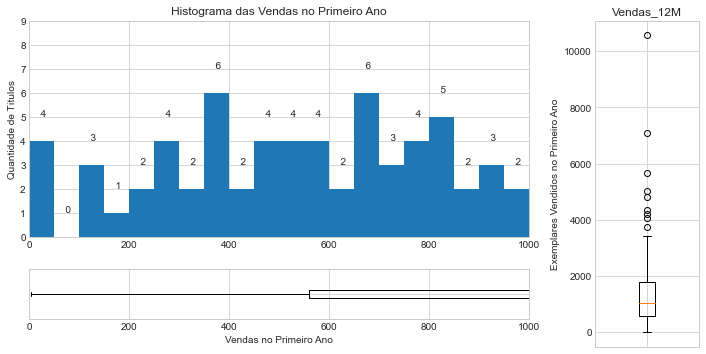

In [9]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(12, 12, (1, 93))

n, val, _ = ax1.hist(x, range=(0, 1000), bins=20)

# Valores de cada bin
for txt, pos in zip(n, val):
    ax1.text(pos + 11, txt+1, '{:3,.0f}'.format(txt))
ax1.set_ylim([0, 9])
ax1.set_xlim([0, 1000])
ax1.set_title('Histograma das Vendas no Primeiro Ano')
ax1.set_ylabel('Quantidade de Títulos')

ax2 = fig.add_subplot(12, 12, (109, 129))

ax2.boxplot(x, vert=False)
ax2.set_xlim([0, 1000])
ax2.set_xlabel('Vendas no Primeiro Ano')
ax2.tick_params(
    axis='y',           # changes apply to the y-axis
    which='both',       # both major and minor ticks are affected
    left=False,         # ticks along the left edge are off
    right=False,        # ticks along the right edge are off
    labelleft=False)    # labels along the left edge are off

ax3 = fig.add_subplot(12, 12, (11, 144))

ax3.boxplot(x)
ax3.set_ylabel('Exemplares Vendidos no Primeiro Ano')
ax3.set_title('Vendas_12M')
ax3.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=False,       # ticks along the bottom edge are off
    top=False,          # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off

plt.show()


<br>

#### Títulos fora da curva:

In [10]:
aux = a['50%'] + 1.5*(a['75%'] - a['25%'])

aux = final.loc[filtro & (final['Vendas_12M'] > aux),
              ['Titulo', 'Vendas_12M']
              ].sort_values('Vendas_12M', ascending=False)\
                    .reset_index()
pd.set_option('display.max_colwidth', 40)
aux.columns = ['ISBN', 'Título', 'Vendas']
aux['Vendas'] = aux['Vendas'].map(
    lambda x: '{:7,.0f}'.format(x).replace(',', '.'))
aux.style.hide_index()

ISBN,Título,Vendas
9788563137289,Do Inferno,10.562
9788595710689,DISCURSO SOBRE O COLONIALISMO,7.089
9788563137258,Thomas Piketty e o Segredo dos Ricos,5.681
9788595710207,Cumbe - Edicao Ampliada,5.008
9788595710139,Angola Janga,4.798
9788563137463,A Clavicula de Salomao,4.348
9788563137319,Caravaggio - A Morte da Virgem,4.187
9788595710399,Carolina - 3 Edicao,4.072
9788563137746,O Caminho do Tarot,3.755
9788595710177,O Livro da Lei,3.414


<br>

## Proporção das vendas nos primeiros meses, em comparação com a venda anual.

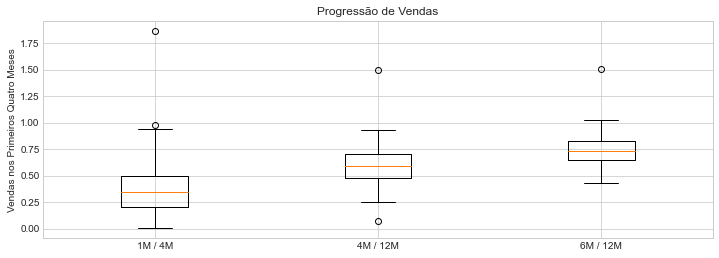

In [11]:
x = final.loc[filtro & (final['Vendas_12M'] < 2873),
              ['Vendas_1M', 'Vendas_4M', 'Vendas_6M', 'Vendas_12M']].dropna().astype(int)

y = x['Vendas_4M'] / x['Vendas_12M']
z = x['Vendas_6M'] / x['Vendas_12M']
x = x['Vendas_1M'] / x['Vendas_4M']

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 1, 1)

ax1.boxplot([x, y, z])
ax1.set_ylabel('Vendas nos Primeiros Quatro Meses')
ax1.set_title('Progressão de Vendas')
ax1.set_xticklabels(['1M / 4M', '4M / 12M', '6M / 12M'])

plt.show()


Como as medianas estão acima das proporções nominais (1/4, 1/3 e 1/2), o gráfico confirma a concentração das vendas nos primeiros meses

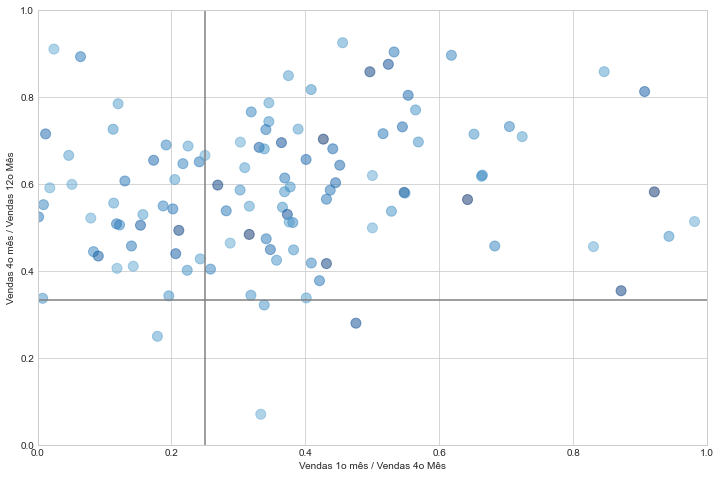

In [12]:
x = final.loc[filtro & (final['Vendas_12M'] < 2873),
              ['Vendas_1M', 'Vendas_4M', 'Vendas_12M']].dropna().astype(int)

y = x['Vendas_4M'] / x['Vendas_12M']
z = x['Vendas_12M']
x = x['Vendas_1M'] / x['Vendas_4M']

fig = plt.figure(figsize=(12, 8))

# Deixa o colormap mais escuro
cmap = mpl.cm.Blues(np.linspace(0, 1, 20))
cmap = mpl.colors.ListedColormap(cmap[10:, :-1])

ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(x=x, y=y, c=z, s=100, cmap=cmap, alpha=0.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Vendas 1o mês / Vendas 4o Mês')
ax1.set_ylabel('Vendas 4o mês / Vendas 12o Mês')
ax1.add_line(line.Line2D([1/4, 1/4], [0, 1], color='gray'))
ax1.add_line(line.Line2D([0, 1], [1/3, 1/3], color='gray'))
plt.show()


Examinando o gráfico acima, nãoé possivel detectar um padrão ou agrupamento de produtos. O gráfico apenas confirma que há uma concentração das vendas nos primeiros meses de venda. A tiragem parece não ter uma relação direta com a proporção das vendas.

## Análise do Giro Consignado

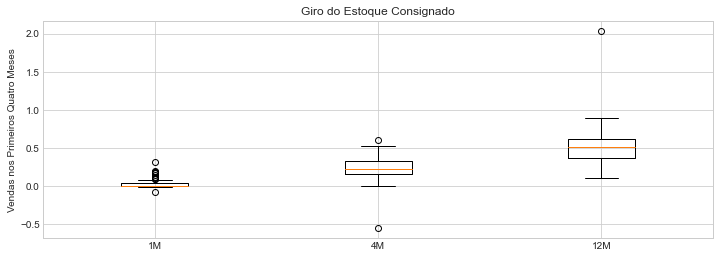

In [13]:
x = final.loc[filtro,
              ['Ven_Cons_1M', 'Ven_Cons_4M', 'Ven_Cons_12M',
               'Est_Cons_1M', 'Est_Cons_4M', 'Est_Cons_12M']]

y = (x['Ven_Cons_4M'] / x['Est_Cons_4M']).dropna()
z = (x['Ven_Cons_12M'] / x['Est_Cons_12M']).dropna()
x = (x['Ven_Cons_1M'] / x['Est_Cons_1M']).dropna()

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 1, 1)

ax1.boxplot([x, y, z])
ax1.set_ylabel('Vendas nos Primeiros Quatro Meses')
ax1.set_title('Giro do Estoque Consignado')
ax1.set_xticklabels(['1M', '4M', '12M'])

plt.show()


<br>

### Giro dos Consignados no Primeiro Ano
<br>

In [14]:
x = final.loc[filtro, ['Ven_Cons_12M', 'Est_Cons_12M']].dropna()
x = (x['Ven_Cons_12M'] / x['Est_Cons_12M']).dropna()

a = x.describe()

print('Quantidade de Títulos:' + (20*' ') +
      '{:9,.0f}'.format(a[0]).replace(',', '.'))
print('Média de exemplares Vendidos em 12 meses: ' +
      '{:9,.0f}'.format(a[1]).replace(',', '.'))
print('Menor giro em 12 meses:' + (19*' ') +
      '{:9,.0%}'.format(a[3]).replace(',', '.'))
print('Primeiro Quartil (25%):' + (19*' ') +
      '{:9,.0%}'.format(a[4]).replace(',', '.'))
print('Segundo  Quartil (50%):' + (19*' ') +
      '{:9,.0%}'.format(a[5]).replace(',', '.'))
print('Terceiro Quartil (75%):' + (19*' ') +
      '{:9,.0%}'.format(a[6]).replace(',', '.'))
print('Maior Giro em 12 meses:' + (19*' ') +
      '{:9,.0%}'.format(a[7]).replace(',', '.'))

Quantidade de Títulos:                          108
Média de exemplares Vendidos em 12 meses:         1
Menor giro em 12 meses:                         10%
Primeiro Quartil (25%):                         36%
Segundo  Quartil (50%):                         51%
Terceiro Quartil (75%):                         62%
Maior Giro em 12 meses:                        204%


<br>

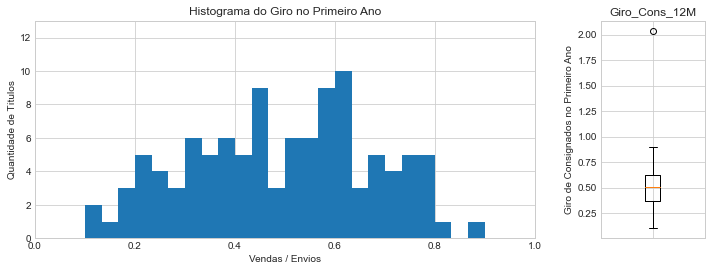

In [15]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 12, (1, 9))

n, val, _ = ax1.hist(x, range=(0, 1), bins=30)

# Valores de cada bin
#for txt, pos in zip(n, val):
#    ax1.text(pos + 11, txt+1, '{:,.0f}'.format(txt))
ax1.set_ylim([0, 13])
ax1.set_xlim([0, 1])
ax1.set_title('Histograma do Giro no Primeiro Ano')
ax1.set_xlabel('Vendas / Envios')
ax1.set_ylabel('Quantidade de Títulos')

ax2 = fig.add_subplot(1, 12, (11, 12))

ax2.boxplot(x)
ax2.set_ylabel('Giro de Consignados no Primeiro Ano')
ax2.set_title('Giro_Cons_12M')
ax2.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=False,       # ticks along the bottom edge are off
    top=False,          # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off

plt.show()


<br>

### Maiores Giros de Consignação em 12 meses

In [16]:
y = pd.concat([final['Titulo'],
           x.sort_values(axis=0, ascending=False).head(10).rename('Giro')], join='inner', axis=1).sort_values(by='Giro', ascending=False)

y['Giro'] = y['Giro'].map(lambda x: '{:8,.1%}'.format(x).replace(',', '.'))
y

,Titulo,Giro
9788563137043,O Livro dos Santos,203.8%
9788563137463,A Clavicula de Salomao,89.5%
9788595710207,Cumbe - Edicao Ampliada,81.1%
9788595710153,Ayako,79.1%
9788595710177,O Livro da Lei,79.0%
9788563137258,Thomas Piketty e o Segredo dos Ricos,77.6%
9788563137531,Coltrane,77.4%
9788563137647,Bukowski: Vida e loucuras de um velh...,77.0%
9788563137746,O Caminho do Tarot,76.6%
9788595710139,Angola Janga,76.0%


<br>

### Maiores Vendas de Consignação em 12 meses

In [17]:
x = final.loc[filtro, ['Titulo', 'Ven_Cons_12M']].dropna().sort_values(
    'Ven_Cons_12M', ascending=False).head(10).rename({'Ven_Cons_12M': 'Vendas'}, axis=1).astype({'Vendas': int})
x['Vendas'] = x['Vendas'].map(lambda x: '{:8,.0f}'.format(x).replace(',', '.'))
x

,Titulo,Vendas
9788563137258,Thomas Piketty e o Segredo dos Ricos,3.793
9788563137463,A Clavicula de Salomao,3.466
9788563137395,Zumbis para Colorir,2.773
9788563137289,Do Inferno,2.671
9788563137746,O Caminho do Tarot,2.416
9788595710177,O Livro da Lei,2.409
9788595710207,Cumbe - Edicao Ampliada,2.363
9788595710139,Angola Janga,2.301
9788563137272,O Capital,1.716
9788563137319,Caravaggio - A Morte da Virgem,1.596


<br>

## Vendas Para o Governo

In [18]:
GOVERNO = ['49269244000163', '49269244000325', '46392114000125',
           '51531051000180', '96291141013834', '06265064000109',
           '00378257000181', '00375114000116']

x = notas.loc[notas['CNPJ'].isin(GOVERNO), ['Emissao', 'CNPJ', 'Cliente',
                                            'Receita Líquida']]

y = x.groupby(['CNPJ', 'Cliente']).sum()
y['Receita Líquida'] = y['Receita Líquida'].map(
    lambda x: '{:10,.2f}'.format(x).replace(',', '#').format(x).replace('.', ',').format(x).replace('#', '.'))
y


,,Receita Líquida
CNPJ,Cliente,
00375114000116,DEFENSORIA PUBLICA DA UNIAO,"35.966,98"
00378257000181,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO - FNDE,"3.700.550,35"
06265064000109,GM QUALITY COMERCIO LTDA,"218.457,46"
46392114000125,Secretaria Municipal De Educacao,"162.692,20"
49269244000163,Sao Paulo Secretaria Municipal De Cultura,"31.828,35"
49269244000325,SECRETARIA MUNICIPAL DE CULTURA,"21.905,65"
51531051000180,Secretaria de Estado da Cultura,"0,00"
96291141013834,SECRETARIA DA ADMINISTRACAO PENITENCIARIA,"0,00"


In [19]:
x = x.groupby(pd.Grouper(key='Emissao', freq='MS')).sum()

x = x.loc[x['Receita Líquida'] != 0, ]
x['Receita Líquida'] = x['Receita Líquida'].map(
    lambda x: '{:10,.2f}'.format(x).replace(',', '#')
    .replace('.', ',').replace('#', '.'))
x

,Receita Líquida
Emissao,
2017-01-01,"14.300,65"
2017-11-01,"21.905,65"
2019-01-01,"148.391,55"
2019-02-01,"2.235.936,24"
2019-04-01,"22.560,00"
2019-07-01,"31.828,35"
2019-10-01,"913.186,82"
2019-11-01,"65.765,08"
2019-12-01,"-2.803,32"


In [20]:
del x, y, z, a, val, n, pos, txt

<br>

## Pré-Venda

In [21]:
mov = pd.read_pickle(PATH + 'movimentos.pkl')
x = mov.loc[mov['cfo_descri'] == 'VENDA / PRE-VENDA'].groupby(pd.Grouper(key='emissa', freq='MS'))['total'].sum().rename('Pré-Venda', axis=1)
x = x.map(lambda x: '{:10,.2f}'.format(x).replace(',', '#')
      .replace('.', ',').replace('#', '.'))
x = pd.DataFrame(x)
x.index.names = ['Mês']
x

,Pré-Venda
Mês,
2021-03-01,"2.689,54"
2021-04-01,"7.055,69"
2021-05-01,"2.156,93"
2021-06-01,"4.068,91"
2021-07-01,"6.662,39"
2021-08-01,"5.479,08"
2021-09-01,"12.985,18"


In [22]:
#! jupyter nbconvert --to html  --no-input analise_lancamentos.ipynb --output-dir=C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-custo\\html
